## Logistic Regression Coefficients

Linear regression predicts a quantitative response Y on the basis of predictor variables X1, X2, ... Xn. It assumes that there is a linear relationship between X(s) and Y. Mathematically, we write this linear relationship as Y ≈ β0 + β1X1 + β2X2 + ... + βnXn.

**The magnitude of the coefficients is directly influenced by the scale of the features**. Therefore, to compare coefficients across features, it is important that all features are on a similar scale. This is why normalisation is important for variable importance and feature selection in linear models.

Linear Regression makes the following assumptions:

- There is a linear relationship betweent the predictors Xs and the outcome Y

- The residuals follow a normal distribution centered at 0

- There is little or no multicollinearity among predictors (Xs should not be linearly related to one another)

- Homoscedasticity (variance should be the same)

Homoscedasticity, also known as homogeneity of variance, describes a situation in which the error term (that is, the "noise" or random disturbance in the relationship between the independent variables (Xs) and the dependent variable (Y)) is the same across all values of the independent variables.

Therefore, there are a lot of assumptions that need to be met in order to make a fair comparison of the features by using only their regression coefficients.

In addition, these coefficients may be penalised by regularisation, therefore being smaller than if we were to compare the relationship of each feature with the target individually.

Having said this, you can still select features based on linear regression coefficients, provided you keep all of these in mind at the time of analysing the outcome.

Personally, this is not my feature selection method of choice, although I find it useful to interpret the output of the model.

I will demonstrate how to select features based in a regression and a classification scenario.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

from sklearn.metrics import roc_auc_score, r2_score
from sklearn.model_selection import train_test_split


from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel

# importing
from helper_fe_v2 import (
            get_full_datapath_nm,
            read_df_from_file,
            check_module_members,
            gen_correlation,
            do_bkwd_fwd_selection,
            yaml_path,
            read_yaml_conf,
            run_randomForestClassifier,
            run_randomForestRegressor
)

In [2]:
config = read_yaml_conf(yaml_path())
print ("yaml_ conf ", config ) 

yaml_ conf  {'write_file': True, 'base_dir': 'C:\\Users\\Arindam Banerji\\CopyFolder\\IOT_thoughts\\python-projects\\kaggle_experiments', 'full_config_file': 'C:\\Users\\Arindam Banerji\\CopyFolder\\IOT_thoughts\\python-projects\\kaggle_experiments\\py-projects.yaml', 'cur_kaggle_expt': 'C:\\Users\\Arindam Banerji\\CopyFolder\\IOT_thoughts\\python-projects\\kaggle_experiments\\feature-engineering\\fe-recipes', 'files': {'test_data_set2': 'fselect_dataset_2.csv', 'housing_data': 'housing_prices_train.csv', 'test_data_set1': 'fselect_dataset_1.csv', 'titanic_data': 'fe-cookbook-titanic.csv', 'comp_eda_file': 'none.csv'}, 'project_parms': {'use_mlxtnd': 'False'}, 'process_eda': {'main_file': 'fselect_dataset_2.csv', 'compre_file': 'none.csv', 'pairwise_analysis': 'on', 'show_html': 'False'}, 'RandomForestConfig': {'n_estimators': 200, 'rand_state': 39, 'max_depth': 4}}


## Classification 

In [3]:
data = read_df_from_file ( config['files']['test_data_set2'], set_nrows=False, nrws=0 ) 
data.shape

Full path NM exists  C:\Users\Arindam Banerji\CopyFolder\IOT_thoughts\python-projects\kaggle_experiments\input_data\fselect_dataset_2.csv


(50000, 109)

In [4]:
data.head() 

,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,...,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109
0,4.532710,3.280834,17.982476,4.404259,2.349910,0.603264,2.784655,0.323146,12.009691,0.139346,...,2.079066,6.748819,2.941445,18.360496,17.726613,7.774031,1.473441,1.973832,0.976806,2.541417
1,5.821374,12.098722,13.309151,4.125599,1.045386,1.832035,1.833494,0.709090,8.652883,0.102757,...,2.479789,7.795290,3.557890,17.383378,15.193423,8.263673,1.878108,0.567939,1.018818,1.416433
2,1.938776,7.952752,0.972671,3.459267,1.935782,0.621463,2.338139,0.344948,9.937850,11.691283,...,1.861487,6.130886,3.401064,15.850471,14.620599,6.849776,1.098210,1.959183,1.575493,1.857893
3,6.020690,9.900544,17.869637,4.366715,1.973693,2.026012,2.853025,0.674847,11.816859,0.011151,...,1.340944,7.240058,2.417235,15.194609,13.553772,7.229971,0.835158,2.234482,0.946170,2.700606
4,3.909506,10.576516,0.934191,3.419572,1.871438,3.340811,1.868282,0.439865,13.585620,1.153366,...,2.738095,6.565509,4.341414,15.893832,11.929787,6.954033,1.853364,0.511027,2.599562,0.811364


In [5]:
# separate train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['target'], axis=1),
    data['target'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((35000, 108), (15000, 108))

In [6]:
# we will scale the variables, so we fit a scaler

scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [7]:
# here I will do the model fitting and feature selection
# altogether in 2 lines of code

# first I specify the Logistic Regression model, here I
# select the Ridge Penalty (l2)(it is the default parameter in sklearn)

# remember that here I want to evaluate the coefficient magnitud
# itself and not whether lasso shrinks coefficients to zero

# ideally, I want to avoid regularisation at all, so the coefficients
# are not affected (modified) by the penalty of the regularisation

# In order to do this in sklearn, I set the parameter C really high
# which is basically like fitting a non-regularised logistic regression

# Then I use the selectFromModel object from sklearn
# to automatically select the features

# set C to 1000, to avoid regularisation
sel_ = SelectFromModel(
    LogisticRegression(C=1000, penalty='l2', max_iter=300, random_state=10))

sel_.fit(scaler.transform(X_train), y_train)

SelectFromModel(estimator=LogisticRegression(C=1000, max_iter=300,
                                             random_state=10))

In [8]:
# this command let's me visualise those features that were kept.

# sklearn will select those features which coefficients are greater
# than the mean of all the coefficients.

# it compares absolute values of coefficients. More on this in a second.

sel_.get_support()

array([False, False,  True, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False,  True, False,  True,  True, False,  True, False,
       False, False, False, False,  True,  True, False, False, False,
       False, False,  True,  True, False, False, False, False, False,
       False, False,  True, False,  True, False,  True, False, False,
        True,  True, False, False, False,  True, False,  True, False,
       False, False, False, False,  True,  True, False,  True, False,
        True, False, False,  True, False, False,  True, False, False,
        True,  True, False, False, False,  True,  True, False,  True,
       False,  True, False, False, False, False,  True, False,  True,
       False,  True, False, False, False,  True, False, False, False])

In [9]:
# let's add the variable names and order it for clearer visualisation
# and then let's sum the number of selected features

selected_feat = X_train.columns[(sel_.get_support())]
len(selected_feat)

33

In [10]:
# with the parameter coef_ we access the coefficients of the variables
# for the linear regression (for all the 108 variables)

sel_.estimator_.coef_

array([[ 1.14975309e-02, -1.33923527e-02,  1.08925675e-01,
         2.65107329e-02,  4.33302846e-02, -2.46367439e-02,
        -3.34458509e-02, -6.31605964e-03,  2.32353835e-02,
        -9.80432989e-03,  8.03340697e-02,  5.29933510e-02,
        -3.74940094e-02,  1.92588915e-02, -3.86791881e-02,
         2.46144911e-02,  1.36320761e-02,  5.42112443e-02,
         1.31256794e-02,  1.54059812e-02,  1.41752719e-01,
         2.43310100e-02, -1.28426535e-01,  1.26389765e-01,
         1.43656199e-02,  6.34510947e-02,  2.76621916e-02,
        -8.68939659e-04, -1.43153012e-02, -1.44424432e-02,
         6.83437169e-03, -1.86231788e-01, -1.01184144e-01,
         3.28268332e-02,  1.18827557e-02,  4.36231846e-02,
         1.96027379e-02,  4.49184192e-02,  7.94096578e-02,
         7.02820092e-02, -3.53870607e-03, -2.07089746e-03,
        -5.35242070e-02,  5.64950368e-02,  3.65517749e-03,
         3.03988358e-02,  4.87916165e-03,  4.26703422e-01,
         2.15268632e-02,  7.38517233e-02,  1.50892083e-0

In [11]:
# as SelectFromModel selects coefficients above the mean
# of all coefficients, let's calculate first the mean

sel_.estimator_.coef_.mean()

0.012000358360807713

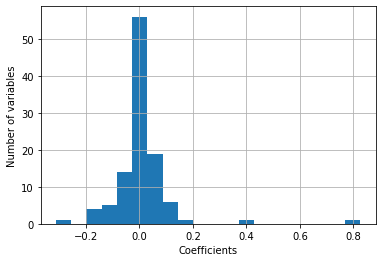

In [12]:
# and now let's plot the distribution of coefficients

pd.Series(sel_.estimator_.coef_.ravel()).hist(bins=20)
plt.xlabel('Coefficients')
plt.ylabel('Number of variables')
plt.show()

As expected, some coefficients are positive and some are negative, suggesting that some features are negatively associated with the outcome (the more of the feature the less of the outcome) and viceversa.

However, the absolute value of the coefficients inform about the importance of the feature on the outcome, and not the sign. Therefore, the feature selection is done filtering on absolute values of coefficients. See below.

In [13]:
# the feature importance is informed by the absolute value of
# the coefficient, and not the sign.
# therefore, let's recalculate the mean using the absolute values instead

np.abs(sel_.estimator_.coef_).mean()

0.05690016526593549

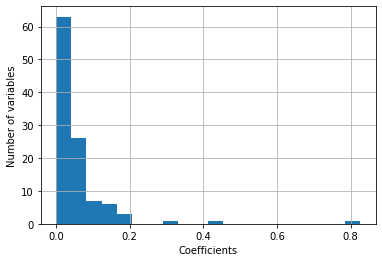

In [14]:
# and now let's plot the histogram of absolute coefficients

pd.Series(np.abs(sel_.estimator_.coef_).ravel()).hist(bins=20)
plt.xlabel('Coefficients')
plt.ylabel('Number of variables')
plt.show()

In [15]:
# and now, let's compare the  number of selected features
# with the number of features which coefficient is above the
# mean coefficient, to make sure we understand the output of
# SelectFromModel

print('total features: {}'.format((X_train.shape[1])))

print('selected features: {}'.format(len(selected_feat)))

print(
    'features with coefficients greater than the mean coefficient: {}'.format(
        np.sum(
            np.abs(sel_.estimator_.coef_) > np.abs(
                sel_.estimator_.coef_).mean())))

total features: 108
selected features: 33
features with coefficients greater than the mean coefficient: 33


Therefore, we see how select from model works. It will select all the coefficients which absolute values are greater than the mean.

To do this, you need to change the default value of the parameter threshold that can be passed to SelectFromModel. More details in the Scikit-learn documentation: https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html


## Linear Regression Coefficients

In this notebook, we repeat the feature selection based of variable coefficients returned by a linear model. This time on a regression scenario.

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectFromModel

In [19]:
config = read_yaml_conf(yaml_path())
print ("yaml_ conf ", config ) 

yaml_ conf  {'write_file': True, 'base_dir': 'C:\\Users\\Arindam Banerji\\CopyFolder\\IOT_thoughts\\python-projects\\kaggle_experiments', 'full_config_file': 'C:\\Users\\Arindam Banerji\\CopyFolder\\IOT_thoughts\\python-projects\\kaggle_experiments\\py-projects.yaml', 'cur_kaggle_expt': 'C:\\Users\\Arindam Banerji\\CopyFolder\\IOT_thoughts\\python-projects\\kaggle_experiments\\feature-engineering\\fe-recipes', 'files': {'test_data_set2': 'fselect_dataset_2.csv', 'housing_data': 'housing_prices_train.csv', 'test_data_set1': 'fselect_dataset_1.csv', 'titanic_data': 'fe-cookbook-titanic.csv', 'comp_eda_file': 'none.csv'}, 'project_parms': {'use_mlxtnd': 'False'}, 'process_eda': {'main_file': 'fselect_dataset_2.csv', 'compre_file': 'none.csv', 'pairwise_analysis': 'on', 'show_html': 'False'}, 'RandomForestConfig': {'n_estimators': 200, 'rand_state': 39, 'max_depth': 4}}


In [20]:
data = read_df_from_file ( config['files']['housing_data'], set_nrows=False, nrws=0 ) 
data.shape

Full path NM exists  C:\Users\Arindam Banerji\CopyFolder\IOT_thoughts\python-projects\kaggle_experiments\input_data\housing_prices_train.csv


(1460, 81)

In [21]:
# In practice, feature selection should be done after data pre-processing,
# so ideally, all the categorical variables are encoded into numbers,
# and then you can assess how deterministic they are of the target

# here for simplicity I will use only numerical variables
# select numerical columns:

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerical_vars = list(data.select_dtypes(include=numerics).columns)
data = data[numerical_vars]
data.shape

(1460, 38)

In [22]:
# separate train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['SalePrice'], axis=1),
    data['SalePrice'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((1022, 37), (438, 37))

In [23]:
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

In [24]:
# the features in the house dataset are in different scales
# so we train a scaler to scale them

scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [25]:
# we train a Linear regression model and select
# features with higher coefficients.

# the LinearRegression object from sklearn is a non-regularised
# linear method. It fits by matrix multiplication and not 
# gradient descent.

# therefore we don't need to specify penalty and other parameters

sel_ = SelectFromModel(LinearRegression())

sel_.fit(scaler.transform(X_train), y_train)

SelectFromModel(estimator=LinearRegression())

In [26]:
# let's count the number of variables selected
selected_feat = X_train.columns[(sel_.get_support())]

len(selected_feat)

7

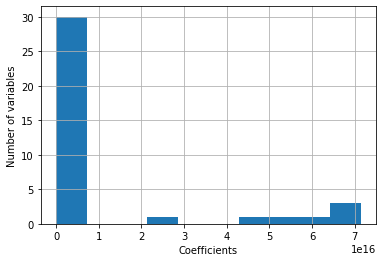

In [27]:
# and now let's plot the histogram of absolute coefficients

pd.Series(np.abs(sel_.estimator_.coef_).ravel()).hist(bins=10)
plt.xlabel('Coefficients')
plt.ylabel('Number of variables')
plt.show()

In [28]:
# and now, let's compare the  amount of selected features
# with the amount of features which coefficient is above the
# mean coefficient, to make sure we understand the output of
# sklearn

print('total features: {}'.format((X_train.shape[1])))

print('selected features: {}'.format(len(selected_feat)))

print(
    'features with coefficients greater than the mean coefficient: {}'.format(
        np.sum(
            np.abs(sel_.estimator_.coef_) > np.abs(
                sel_.estimator_.coef_).mean())))

total features: 37
selected features: 7
features with coefficients greater than the mean coefficient: 7


Same as before, it selects those features which coefficient are greater than the mean of all feature coefficients.
